# LSTM-VQE with UCCSD ansatz For Molecule



- optimizer = SGD, ADAM in veq_optimization
- if you want to use VQE with SPSA, use the function vqe_molecule_spsa and vqe_optimization_spsa for test (not for train)
- learnin rate = stational or dynamical (lr_schedule)
- loss function = weighted or descent in train_step_u, remember to adjust

In [ ]:
!pip install pennylane
!pip install aiohttp fsspec h5py
!pip install pennylane-lightning
#!python -m pip install pennylane pennylane-lightning pennylane-lightning-gpu --upgrade
#!pip install custatevec-cu12
import numpy as np
import pandas as pd
import pennylane as qml
from pennylane import qchem
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.optimize import minimize
import optax
from jax import numpy as np
import jax
import time
import jax.numpy as jnp
from jax import random
import h5py
import os
import logging

# 設置靜音等級
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 僅顯示錯誤，忽略警告
tf.get_logger().setLevel(logging.ERROR)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 36.8 MB/s eta 0:00:00


## Load data

In [ ]:
def load_data(molecule, basis="STO-3G"):
  data_list = []

  for mol,bondlengths in molecule:
    # If bondlengths is None, load default bond length
    if bondlengths is None:
      data = qml.data.load("qchem", molname=mol, basis=basis)
      #print(f"{data[0].molecule},{data[0].bondlength}")

    else:
      # Otherwise, iterate over the bond lengths
      data = qml.data.load("qchem", molname=mol, basis=basis, bondlength=bondlengths)
      #print(f"{data[0].molecule},{data[0].bondlength}")

    for entry in data:
      data_list.append(entry)

  df = pd.DataFrame(data_list)
  return df

# Input molecule data
# HeH2 only has 6-31G, also, C2H6, CO2, N2H4, C2H4, N2H2, CH2O, C2H2 no data
# molecule = ["LiH", "Li2", "N2", "CO2", "BH3", "H2O2", "O2", "CO", "C2", "H4", "BeH2", "H3+", "NH3", "H2O",
            #"CH4", "HeH+", "H8", "H10", "NeH+", "OH-", "H6", "HF", "H2"]

In [ ]:
# display the information of molecule
# find the index
def display_data(dataset, molecule_name, attribute = False):

  if attribute is True:
    print("Available attributes in qchem")
    print(qml.data.list_attributes(data_name="qchem"))

  for i in range(len(dataset[0])):
    if dataset[0][i].molname == molecule_name:
      data = dataset[0][i]

      print(f"Index : {i}")
      print(f"Molecule : {data.molecule}")
      print(f"Molecule : {data.basis}"   )
      print(f"HF state : {data.hf_state}")
      print(f"hamiltonian : {data.hamiltonian}")
      print(f"VQE energy : {data.vqe_energy}")
      print(f"VQE gates : {data.vqe_gates}")
      print(f"VQE params : {data.vqe_params}")
      print(f"Bondlength: {data.bondlength}")
      print(f"FCI gates : {data.fci_energy}")

## Proprocess

In [ ]:
def electrons_and_orbitals(hf_state):
  electrons = sum(hf_state)
  orbitals = int(len(hf_state))

  return electrons, orbitals

In [ ]:
def max_params (dataset):
  max_s_wires = 0
  max_d_wires = 0

  for data in dataset:
    electrons, orbitals = electrons_and_orbitals(data.hf_state)

    single, double = qchem.excitations(electrons, orbitals)
    s_w, d_w = qml.qchem.excitations_to_wires(single, double)
    single = len(s_w)
    double = len(d_w)
    max_s_wires = max(max_s_wires, single)
    max_d_wires = max(max_d_wires, double)

  return max_s_wires, max_d_wires

## Model

In [ ]:
def vqe_molecule_u(data,max_qubits):

  # Number of qubits (wires) equal to the max qubits
  wires = range(max_qubits)
  # Number of qubits (wires) equal to the number of qubits required for the HF state
  orbitals = len(data.hf_state)
  # the number of electrons and molecules
  electrons = sum(data.hf_state)
  # the wires of single and double excitations
  single_wires, double_wires = qchem.excitations(electrons,orbitals)

  s_wires, d_wires = qml.qchem.excitations_to_wires(single_wires, double_wires)

  num_single = len(d_wires)
  num_double = len(s_wires)

  single_mapping = tf.keras.layers.Dense(num_single, use_bias=False)
  double_mapping = tf.keras.layers.Dense(num_double, use_bias=False)
  # Create the actual quantum circuit for the VQE algorithm

  def circuit(params, wires):

    # the params for single and double excitations
    params = tf.reshape(params, (-1,))

    half_dim = fixed_param_dim // 2
    single_input = params[:half_dim]
    double_input = params[half_dim:]
    #single_params = params[:num_single]
    single_params_full = single_mapping(tf.expand_dims(single_input, 0))[0]  # new
    double_params_full = double_mapping(tf.expand_dims(double_input, 0))[0]  # new

    #single_params = single_mapping(tf.expand_dims(single_input, 0))[0]  # (num_single,)
    #double_params = double_mapping(tf.expand_dims(double_input, 0))[0]

    single_params = single_params_full[:num_single]
    double_params = double_params_full[:num_double]

    #double_params = params[max_s_params: max_s_params + num_double]
    mapped_params = tf.concat([single_params, double_params], axis=0)

    #initial_params_u = tf.concat([single_params, double_params], axis=0)

    # something we want to train, ansatz
    qml.UCCSD(mapped_params, range(orbitals), s_wires, d_wires, data.hf_state)

    return qml.expval(data.hamiltonian)

  # Evaluates the cost Hamiltonian
  def hamiltonian_cost(params, **kwargs):
    # Define device
    # This qnode evaluates the expectation value of the cost hamiltonian operator
    dev = qml.device("lightning.qubit", wires=wires)
    cost = qml.QNode(circuit, dev, diff_method="adjoint", interface="tf")

    return cost(params, wires = wires)

  return hamiltonian_cost

In [ ]:
def vqe_optimization(molecule_cost, initial_params, max_iter=10, learning_rate=0.1, conv_tol = 1e-6, optimizer = "ADAM"):

    if optimizer == "ADAM":
      opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)

    elif optimizer == "SGD":
      opt = tf.keras.optimizers.SGD(learning_rate = learning_rate)
    # opt = qml.AdamOptimizer(stepsize=learning_rate)

    # 初始化变量来存储迭代信息
    params = tf.Variable(initial_params)
    energy_history = [molecule_cost(params)]
    param_history = [params]
    conv_iter = max_iter

    # 优化循环
    for iteration in range(max_iter):
        # 计算梯度并更新参数
        with tf.GradientTape() as tape:
            cost = molecule_cost(params)
        gradient = tape.gradient(cost, params)

        opt.apply_gradients(zip([gradient],[params]))
        param_history.append(params)
        energy_history.append(molecule_cost(params))

        conv = np.abs(energy_history[-1].numpy() - energy_history[-2].numpy())

        # 打印当前迭代的参数和能量值
        if iteration%50 == 0:
          print(f"Step =  {iteration+1}/{max_iter}, Energy= {energy_history[-1]:.8f} Ha")

        if conv <= conv_tol:
          conv_iter = iteration+1
          break

    # 返回优化后的参数和能量值，以及每次迭代的记录
    return conv_iter, param_history[-1], energy_history[-1], param_history, energy_history

In [ ]:
def vqe_optimization_u_spsa(qnode, initial_params, max_iter=10, alpha = 0.2, gamma = 0.101, c = 0.15, conv_tol=1e-6):

    opt = qml.SPSAOptimizer(maxiter=max_iter, alpha=alpha, gamma=gamma, c=c)

    params = np.array(initial_params, dtype = float)
    energy_history = []
    param_history = []

    current_energy = qnode(params)
    energy_history.append(current_energy)
    param_history.append(params.copy())

    for iteration in range(max_iter):

        new_params, new_energy  = opt.step_and_cost(qnode, params)
        energy_history.append(new_energy)
        param_history.append(new_params.copy())

        conv = abs(new_energy - current_energy)

        params = new_params
        current_energy = new_energy

        if iteration % 10 == 0:
            print(f"Step = {iteration+1}/{max_iter}, Energy= {new_energy:.8f} Ha")

        if conv < conv_tol:
            print(f"Converged in {iteration+1} steps.")
            return iteration+1, params, new_energy, param_history, energy_history

    return max_iter, params, new_energy, param_history, energy_history

In [ ]:
def rnn_iteration_u(inputs, molecule_cost):
    """Perform a single time step in the computational graph of the custom RNN."""

    prev_cost, prev_params, prev_h, prev_c = inputs

    new_input = tf.keras.layers.concatenate([prev_cost, prev_params])
    new_input = tf.expand_dims(new_input, axis=1)

    outputs, new_h, new_c = rnn_layer(new_input, initial_state=[prev_h, prev_c])
    new_params = tf.squeeze(outputs, axis=1)

    #_params = tf.reshape(new_params, shape=(1,param_dim))

    _cost = molecule_cost(new_params)
    new_cost = tf.reshape(tf.cast(_cost, dtype=tf.float32), shape=(1, 1))

    return [new_cost, new_params, new_h, new_c]


In [ ]:
def recurrent_loop_u(molecule_cost, steps = 5, LossFunction = "weighted", intermediate_steps=False):
    """Creates the recurrent loop for the Recurrent Neural Network."""

    initial_cost = tf.zeros(shape=(1, 1), dtype=tf.float32)
    initial_params = tf.zeros((1, fixed_param_dim), dtype=tf.float32)
    initial_h = tf.zeros(shape=(1, fixed_param_dim), dtype=tf.float32)
    initial_c = tf.zeros(shape=(1, fixed_param_dim), dtype=tf.float32)

    inputs = [initial_cost, initial_params, initial_h, initial_c]
    param_outputs = []
    cost_outputs = []


    for _ in range(steps):
      inputs = rnn_iteration_u(inputs, molecule_cost)
      param_outputs.append(inputs[1])
      cost_outputs.append(inputs[0])

    loss = 0.0

    if LossFunction == "weighted":

      loss = 0.0

      for t in range(len(cost_outputs)):
        coeff = 0.1*(t+1)
        loss += cost_outputs[t]*coeff

      loss = loss/len(cost_outputs)

    elif LossFunction == "descent":
      min_cost = cost_outputs[0]

      for t in range(1,len(cost_outputs)):
        min_cost_j = cost_outputs[t-1]

        for j in range(t):
          if cost_outputs[j] < min_cost_j:
            min_cost_j = cost_outputs[j]
        loss += cost_outputs[t] - min_cost_j

    #min_cost = cost_outputs[0]

    #for t in range(1,len(cost_outputs)):
    #  min_cost = tf.minimum(min_cost, cost_outputs[t-1]) #t and max(next line) is good too
    #  loss += tf.maximum(0.0, cost_outputs[t] - min_cost)

    if intermediate_steps:
        return param_outputs + [loss]
    else:
        return loss

In [ ]:
def train_step_u(molecule_cost , LossFunction = "weighted", steps = 10):
    """Single optimization step in the training procedure."""

    with tf.GradientTape() as tape:
        loss = tf.cast(recurrent_loop_u(molecule_cost=molecule_cost, steps = steps, LossFunction = LossFunction), dtype=tf.float32)
    # Evaluates gradients, cell is the LSTM cell defined previously
    grads = tape.gradient(loss, rnn_layer.trainable_weights+ single_mapping.trainable_weights + double_mapping.trainable_weights)

    #print("Gradients:", grads)

    # Apply gradients and update the weights of the LSTM cell
    opt_u.apply_gradients(zip(grads, rnn_layer.trainable_weights+ single_mapping.trainable_weights + double_mapping.trainable_weights))

    return loss

## Dowload data and proprocess

In [ ]:
molecule = [
    ("H2", [0.5]),
    ("H2", [0.54]),
    ("H2", [0.58]),
    ("H2", [0.62]),
    ("H2", [0.66]),
    ("H2", [0.82]),
    ("H2", [0.86]),
    ("H2", [0.9]),
    ("H2", [0.94]),
    ("H2", [0.98]),
    ("H2", [1.02]),
    ("H2", [1.06]),
    ("H2", [1.1]),
    ("H2", [1.14]),
    ("H2", [1.18]),
    ("H2", [1.22]),
    ("H2", [1.26]),
    ("H2", [1.3]),
    ("H2", [1.34]),
    ("H2", [1.38]),
    ("H2", [1.42]),
    ("H2", [1.46]),
    ("H2", [1.5]),
    ("H2", [1.54]),
    ("H2", [1.58]),
    ("H2", [1.62]),
    ("H2", [1.66]),
    ("H2", [1.7]),
    ("H2", [1.74]),
    ("H2", [1.78]),
    ("H2", [1.82]),
    ("H2", [1.86]),
    ("H2", [1.9]),
    ("H2", [1.94]),
    ("H2", [1.98]),
    ("H2", [2.02]),
    ("H2", [2.06]),
    ("H2", [2.1]),
    ("H3+", [0.5]),
    ("H3+", [0.54]),
    ("H3+", [0.58]),
    ("H3+", [0.62]),
    ("H3+", [0.66]),
    ("H3+", [0.7]),
    ("H3+", [0.74]),
    ("H3+", [0.78]),
    ("H3+", [0.82]),
    ("H3+", [0.86]),
    ("H3+", [0.9]),
    ("H3+", [0.94]),
    ("H3+", [0.98]),
    ("H3+", [1.02]),
    ("H3+", [1.06]),
    ("H3+", [1.1]),
    ("H3+", [1.14]),
    ("H3+", [1.18]),
    ("H3+", [1.22]),
    ("H3+", [1.26]),
    ("H3+", [1.3]),
    ("H3+", [1.34]),
    ("H3+", [1.38]),
    ("H3+", [1.42]),
    ("H3+", [1.46]),
    ("H3+", [1.5]),
    ("H3+", [1.54]),
    ("H3+", [0.5]),
    ("H2", None),
    ("H3+", None),
    ("H4", None)

]

In [ ]:
# Load dataset

dataset = load_data(molecule, basis="STO-3G")
print(dataset.head())

                                                   0
0  <Dataset = molname: H2, basis: STO-3G, bondlen...
1  <Dataset = molname: H2, basis: STO-3G, bondlen...
2  <Dataset = molname: H2, basis: STO-3G, bondlen...
3  <Dataset = molname: H2, basis: STO-3G, bondlen...
4  <Dataset = molname: H2, basis: STO-3G, bondlen...


In [ ]:
display_data(dataset = dataset, molecule_name = "H4", attribute = True)

Available attributes in qchem
['basis_rot_groupings', 'basis_rot_samples', 'dipole_op', 'fci_energy', 'fci_spectrum', 'hamiltonian', 'hf_state', 'initial_state_coeffs', 'initial_state_dets', 'molecule', 'number_op', 'optimal_sector', 'paulix_ops', 'qwc_groupings', 'qwc_samples', 'sparse_hamiltonian', 'spin2_op', 'spinz_op', 'symmetries', 'tapered_dipole_op', 'tapered_hamiltonian', 'tapered_hf_state', 'tapered_num_op', 'tapered_spin2_op', 'tapered_spinz_op', 'vqe_energy', 'vqe_gates', 'vqe_params']
Index : 68
Molecule : <Molecule = H4, Charge: 0, Basis: STO-3G, Orbitals: 4, Electrons: 4>
Molecule : STO-3G
HF state : [1 1 1 1 0 0 0 0]
hamiltonian : 0.0077850470101684666 * I(0) + 0.2029572455064479 * Z(0) + 0.202957245506448 * Z(1) + 0.1319392995399748 * (Z(0) @ Z(1)) + -0.004548592840507519 * (Y(0) @ Z(1) @ Z(2) @ Z(3) @ Y(4)) + -0.021657966390520433 * (Y(0) @ Z(2) @ Z(3) @ Y(4)) + -0.004548592840507519 * (X(0) @ Z(1) @ Z(2) @ Z(3) @ X(4)) + -0.021657966390520433 * (X(0) @ Z(2) @ Z(3) @ 

In [ ]:
max_qubits = 0

for i in range(len(dataset[0])):
  if len(dataset[0][i].hf_state) > max_qubits:
    max_qubits = len(dataset[0][i].hf_state)

print(max_qubits)

8


In [ ]:
dataset_list = list(dataset[0])
train_set = dataset_list[:68]
test_set = dataset_list[68]
print(f"train set: {train_set}")
print(f"test set: {test_set}")

train set: [<Dataset = molname: H2, basis: STO-3G, bondlength: 0.5, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.54, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.58, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.62, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.66, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.82, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.86, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.9, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.94, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.98, attributes: ['molname', 'basis', ...]>, <Dataset = molname: 

In [ ]:
max_s_params, max_d_params = max_params(dataset[0])
print(f"the number of max single wires: {max_s_params}")
print(f"the number of max double wires: {max_d_params}")

the number of max single wires: 8
the number of max double wires: 18


## Train

In [ ]:
max_s_params, max_d_params = max_params(dataset[0])
single_mapping = tf.keras.layers.Dense(max_s_params, use_bias=False) #new
double_mapping = tf.keras.layers.Dense(max_d_params, use_bias=False) #new
fixed_param_dim = 40
cell_u = tf.keras.layers.LSTMCell(fixed_param_dim)
rnn_layer = tf.keras.layers.RNN(cell_u, return_sequences=True, return_state=True)

In [ ]:
molecule_cost_list_u = [vqe_molecule_u(m, max_qubits) for m in train_set]

In [ ]:
# Dynamical LR if need
#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate=0.01,
#    decay_steps=100,
#    decay_rate=0.9,
#    staircase=True
#)

opt_u = tf.keras.optimizers.Adam(learning_rate = 0.1)

# Set the number of training epochs
epochs_u = 5
steps_per_epoch_u = 5

previous_mean_loss_u = None

for epoch in range(epochs_u):

    start_time = time.time()

    if epoch % 10 == 0:
      print(f"Epoch {epoch+1}/{epochs_u}")

    epoch_loss_u = []
    for i, molecule_cost in enumerate(molecule_cost_list_u):
        # LossFunction = weighted or descent
        loss_u = train_step_u(molecule_cost, LossFunction = "weighted", steps = steps_per_epoch_u)
        epoch_loss_u.append(loss_u.numpy())

        # Log every 5 batches.
        if i % 10 == 0:
            print(f" > Molecule {i+1}/{len(molecule_cost_list_u)} - Loss: {loss_u.numpy()[0][0]:.8f}") #[0][0]
            print(f" > steps_per_epoch: {steps_per_epoch_u}")

    epoch_loss_u = np.array(epoch_loss_u)
    mean_loss_u = np.mean(epoch_loss_u)

    if epoch % 10 == 0:
      print(f" > Mean loss: {mean_loss_u:.6f}")

    if mean_loss_u > 1e-2:
      steps_per_epoch_u = min(steps_per_epoch_u + 2, 15)
    elif mean_loss_u < 1e-3:
      steps_per_epoch_u = max(steps_per_epoch_u -2, 5)

    #if epoch > 0 and abs(previous_mean_loss - mean_loss) < 1e-4:
     # print(f"Training Converged at Epoch {epoch+1}")
      #break

    if previous_mean_loss_u is not None:
        rel_change_u = abs(previous_mean_loss_u - mean_loss_u) / abs(previous_mean_loss_u)
        if rel_change_u < 1e-4:
            print(f"Training Converged at Epoch {epoch+1}")
            break

    # Update the previous mean loss
    previous_mean_loss_u = mean_loss_u

    end_time = time.time()
    execution_time = end_time - start_time


    print(f"Execution time of train for {epoch+1}: {execution_time:.1f} seconds")

Epoch 1/5
 > Molecule 1/68 - Loss: -0.30783719
 > steps_per_epoch: 5
 > Molecule 11/68 - Loss: -0.30557662
 > steps_per_epoch: 5
 > Molecule 21/68 - Loss: -0.22060712
 > steps_per_epoch: 5
 > Molecule 31/68 - Loss: -0.25416547
 > steps_per_epoch: 5
 > Molecule 41/68 - Loss: -0.21382651
 > steps_per_epoch: 5
 > Molecule 51/68 - Loss: -0.37736565
 > steps_per_epoch: 5
 > Molecule 61/68 - Loss: -0.34473029
 > steps_per_epoch: 5
 > Mean loss: -0.291552
Execution time of train for 1: 91.5 seconds
 > Molecule 1/68 - Loss: -0.31243938
 > steps_per_epoch: 5
 > Molecule 11/68 - Loss: -0.31889457
 > steps_per_epoch: 5
 > Molecule 21/68 - Loss: -0.27510911
 > steps_per_epoch: 5
 > Molecule 31/68 - Loss: -0.25105631
 > steps_per_epoch: 5
 > Molecule 41/68 - Loss: -0.28545189
 > steps_per_epoch: 5
 > Molecule 51/68 - Loss: -0.37573797
 > steps_per_epoch: 5
 > Molecule 61/68 - Loss: -0.34729105
 > steps_per_epoch: 5
Execution time of train for 2: 86.1 seconds
 > Molecule 1/68 - Loss: -0.31342962
 > 

In [ ]:
# save LSTM weight
with h5py.File("vqe_beta_test_2_H4_fixed_40.h5", "w") as f:
    # 儲存 RNN 權重
    rnn_group = f.create_group("rnn_layer")
    for i, w in enumerate(rnn_layer.get_weights()):
        rnn_group.create_dataset(f"weight_{i}", data=w)
    # 儲存 single_mapping 權重
    single_group = f.create_group("single_mapping")
    for i, w in enumerate(single_mapping.get_weights()):
        single_group.create_dataset(f"weight_{i}", data=w)
    # 儲存 double_mapping 權重
    double_group = f.create_group("double_mapping")
    for i, w in enumerate(double_mapping.get_weights()):
        double_group.create_dataset(f"weight_{i}", data=w)

In [ ]:
# load LSTM weight
dummy_input = tf.zeros((1, 1, fixed_param_dim + 1))  # 假設輸入是 [cost, params]
rnn_layer(dummy_input)

with h5py.File("vqe_beta_test_1_H2O.h5", "r") as f:
    # 載入 RNN 權重
    rnn_weights = [f["rnn_layer"][f"weight_{i}"][:] for i in range(len(f["rnn_layer"]))]
    rnn_layer.set_weights(rnn_weights)
    # 載入 single_mapping 權重
    single_weights = [f["single_mapping"][f"weight_{i}"][:] for i in range(len(f["single_mapping"]))]
    single_mapping.set_weights(single_weights)
    # 載入 double_mapping 權重
    double_weights = [f["double_mapping"][f"weight_{i}"][:] for i in range(len(f["double_mapping"]))]
    double_mapping.set_weights(double_weights)

## Result (Loss)

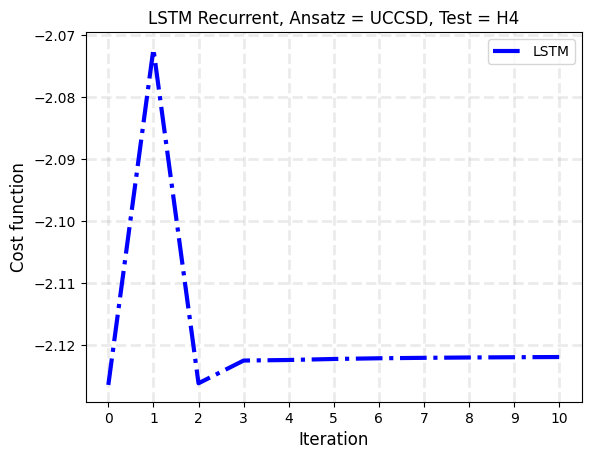

[-2.1264684200286865,
 -2.0722343921661377,
 -2.1262049674987793,
 -2.122535467147827,
 -2.1224453449249268,
 -2.122281789779663,
 -2.1221675872802734,
 -2.1220946311950684,
 -2.122039794921875,
 -2.1219980716705322,
 -2.1219663619995117]

In [ ]:
test_molecule_cost_u = vqe_molecule_u(test_set, max_qubits)

res = recurrent_loop_u(test_molecule_cost_u, steps = 10, LossFunction = "weighted", intermediate_steps=True)

# Extract all angle suggestions
start_zeros = tf.zeros(shape=(fixed_param_dim))
guesses = [start_zeros] + [
    tf.reshape(r, shape=(fixed_param_dim)) for r in res[:-1]
    ]


final_loss = res[-1]

lstm_losses_u = [
    test_molecule_cost_u(tf.reshape(guess, shape=(1, fixed_param_dim)))
    for guess in guesses
]

fig, ax = plt.subplots()

plt.plot(lstm_losses_u, color="blue", lw=3, ls="-.", label="LSTM")

plt.grid(ls="--", lw=2, alpha=0.25)
plt.ylabel("Cost function", fontsize=12)
plt.xlabel("Iteration", fontsize=12)
plt.title("LSTM Recurrent, Ansatz = UCCSD, Test = H4")
plt.legend()
#ax.set_xticks([0, 5, 10, 15, 20])
ax.set_xticks(range(0, len(lstm_losses_u)))
plt.show()

lstm_losses_u = [float(t.numpy()) for t in lstm_losses_u]
lstm_losses_u

## Test (LSTM-VQE)

optimizer = ADAM, SGD,

input the final parameter from LSTM as initial parameter for VQE

In [ ]:
conv_iter_u_sgd, lstm_optimized_params_u_sgd, lstm_optimized_energy_u_sgd, lstm_param_history_u_sgd, lstm_energy_history_u_sgd = vqe_optimization(
    test_molecule_cost_u,
    initial_params=guesses[-1],
    max_iter=500,
    learning_rate=0.1,
    conv_tol = 1e-6,
    optimizer = "SGD"
)

lstm_energy_history_u_sgd = [float(t.numpy()) for t in lstm_energy_history_u_sgd]
lstm_energy_history_u_sgd

Step =  1/500, Energy= -2.13219905 Ha
Step =  51/500, Energy= -2.17627120 Ha
Step =  101/500, Energy= -2.17905951 Ha
Step =  151/500, Energy= -2.17969346 Ha
Step =  201/500, Energy= -2.17995882 Ha
Step =  251/500, Energy= -2.18010998 Ha
Step =  301/500, Energy= -2.18020391 Ha


[-2.1219663619995117,
 -2.1321990489959717,
 -2.1390912532806396,
 -2.144084930419922,
 -2.1479034423828125,
 -2.1509387493133545,
 -2.153420925140381,
 -2.1554956436157227,
 -2.1572608947753906,
 -2.158785343170166,
 -2.16011905670166,
 -2.161299228668213,
 -2.162353754043579,
 -2.163304328918457,
 -2.164168119430542,
 -2.1649584770202637,
 -2.1656854152679443,
 -2.1663577556610107,
 -2.166982412338257,
 -2.167565107345581,
 -2.1681101322174072,
 -2.16862154006958,
 -2.169102907180786,
 -2.1695566177368164,
 -2.169985055923462,
 -2.1703906059265137,
 -2.1707746982574463,
 -2.1711392402648926,
 -2.171485424041748,
 -2.171814441680908,
 -2.1721277236938477,
 -2.1724259853363037,
 -2.172710418701172,
 -2.1729815006256104,
 -2.1732404232025146,
 -2.173487663269043,
 -2.1737236976623535,
 -2.1739494800567627,
 -2.1741652488708496,
 -2.1743717193603516,
 -2.174569606781006,
 -2.1747586727142334,
 -2.1749401092529297,
 -2.1751139163970947,
 -2.1752803325653076,
 -2.1754400730133057,
 -2.1755

In [ ]:
conv_iter_u_adam, lstm_optimized_params_u_adam, lstm_optimized_energy_u_adam, lstm_param_history_u_adam, lstm_energy_history_u_adam = vqe_optimization(
    test_molecule_cost_u,
    initial_params=guesses[-1],
    max_iter=500,
    learning_rate=0.1,
    conv_tol = 1e-6,
    optimizer = "ADAM"
)

lstm_energy_history_u_adam = [float(t.numpy()) for t in lstm_energy_history_u_adam]
lstm_energy_history_u_adam

Step =  1/500, Energy= -2.00187230 Ha
Step =  51/500, Energy= -2.17984247 Ha


[-2.1219663619995117,
 -2.0018723011016846,
 -2.1133766174316406,
 -2.101132869720459,
 -2.120640754699707,
 -2.150891065597534,
 -2.1372907161712646,
 -2.127689838409424,
 -2.147373914718628,
 -2.164876937866211,
 -2.160663604736328,
 -2.151313066482544,
 -2.1550140380859375,
 -2.165651321411133,
 -2.169417381286621,
 -2.165531635284424,
 -2.163454294204712,
 -2.1672401428222656,
 -2.171278238296509,
 -2.1713528633117676,
 -2.1709656715393066,
 -2.172884702682495,
 -2.17435359954834,
 -2.173248529434204,
 -2.1727471351623535,
 -2.1755316257476807,
 -2.178406000137329,
 -2.177570343017578,
 -2.1751463413238525,
 -2.175361394882202,
 -2.177635431289673,
 -2.178576946258545,
 -2.1778969764709473,
 -2.17765212059021,
 -2.178048610687256,
 -2.178093194961548,
 -2.178246259689331,
 -2.1791040897369385,
 -2.1795876026153564,
 -2.1789767742156982,
 -2.178539514541626,
 -2.179189682006836,
 -2.179912805557251,
 -2.1798453330993652,
 -2.179581642150879,
 -2.1796317100524902,
 -2.179689645767212

optimizer = SPSA

In [ ]:
def vqe_molecule_u_spsa(data,max_qubits):

  # define device
  dev = qml.device("lightning.qubit", wires=max_qubits)
  # Number of qubits (wires) equal to the max qubits
  wires = range(max_qubits)
  # Number of qubits (wires) equal to the number of qubits required for the HF state
  orbitals = len(data.hf_state)
  # the number of electrons and molecules
  electrons = sum(data.hf_state)
  # the wires of single and double excitations
  single_wires, double_wires = qchem.excitations(electrons,orbitals)

  s_wires, d_wires = qml.qchem.excitations_to_wires(single_wires, double_wires)

  num_single = len(d_wires)
  num_double = len(s_wires)

  # Create the actual quantum circuit for the VQE algorithm
  @qml.qnode(dev, diff_method = "adjoint", interface="autograd")
  def circuit(params):

    # the params for single and double excitations
    params = tf.reshape(params, (max_s_params + max_d_params,))

    single_params = params[:num_single]

    double_params = params[max_s_params: max_s_params + num_double]

    initial_params_u = tf.concat([single_params, double_params], axis=0)

    # something we want to train, ansatz
    qml.UCCSD(initial_params_u, range(orbitals), s_wires, d_wires, data.hf_state)

    return qml.expval(data.hamiltonian)

  return circuit

In [ ]:
test_molecule_cost_u_spsa = vqe_molecule_u_spsa(test_set, max_qubits)

conv_iter_u_spsa, lstm_optimized_params_u_spsa, lstm_optimized_energy_u_spsa, lstm_param_history_u_spsa, lstm_energy_history_u_spsa = vqe_optimization_u_spsa(
    qnode = test_molecule_cost_u_spsa,
    initial_params=guesses[-1],
    max_iter=300,
    conv_tol = 1e-6,
)

lstm_energy_history_u_adam = [float(t.numpy()) for t in lstm_energy_history_u_adam]
lstm_energy_history_u_adam

Step = 1/100, Energy= -1.92595310 Ha
Converged in 1 steps.


[array(-1.9259531), array(-1.9259531)]

動態調整 learning rate

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1.5,
    decay_steps=10,
    decay_rate=0.9,
    staircase=True
    )

conv_iter_u_dynamical_sgd, lstm_optimized_params_u_dynamical_sgd, lstm_optimized_energy_u_dynamical_sgd, lstm_param_history_u_dynamical_sgd, lstm_energy_history_u_dynamical_sgd = vqe_optimization(
    test_molecule_cost_u,
    initial_params=guesses[-1],
    max_iter=500,
    learning_rate=lr_schedule,
    conv_tol = 1e-6,
    optimizer = "SGD"
)

lstm_energy_history_u_dynamical_sgd = [float(t.numpy()) for t in lstm_energy_history_u_dynamical_sgd]
lstm_energy_history_u_dynamical_sgd

Step =  1/500, Energy= -2.04293132 Ha
Step =  51/500, Energy= -1.25079763 Ha
Step =  101/500, Energy= -2.00983000 Ha
Step =  151/500, Energy= -2.18003702 Ha
Step =  201/500, Energy= -2.18024111 Ha


[-2.1219663619995117,
 -2.042931318283081,
 -0.870267391204834,
 -0.04559452831745148,
 -1.3859567642211914,
 -0.04195033758878708,
 -0.8214665651321411,
 -0.6951251029968262,
 -0.525867223739624,
 -1.713552474975586,
 -0.7877720594406128,
 -0.9358931183815002,
 -0.5371800661087036,
 -1.7774193286895752,
 -0.8759968280792236,
 -0.640662670135498,
 -1.2804728746414185,
 -0.4466417133808136,
 -1.8176733255386353,
 -1.047805905342102,
 -0.5238498449325562,
 -1.8218610286712646,
 -1.3111008405685425,
 -0.8242509365081787,
 -1.833162784576416,
 -0.6649064421653748,
 -1.5973093509674072,
 -0.4210411608219147,
 -2.0495285987854004,
 -1.9938627481460571,
 -1.522447943687439,
 -1.2789337635040283,
 -1.1732532978057861,
 -1.0101515054702759,
 -0.9085348844528198,
 -1.0201845169067383,
 -1.0769425630569458,
 -0.8487387299537659,
 -1.5654284954071045,
 -0.7938189506530762,
 -1.5254484415054321,
 -1.009581446647644,
 -1.4075156450271606,
 -0.9741886258125305,
 -1.5260813236236572,
 -0.9893839955329

In [ ]:
conv_iter_u_dynamical_adam, lstm_optimized_params_u_dynamical_adam, lstm_optimized_energy_u_dynamical_adam, lstm_param_history_u_dynamical_adam, lstm_energy_history_u_dynamical_adam = vqe_optimization(
    test_molecule_cost_u,
    initial_params=guesses[-1],
    max_iter=500,
    learning_rate=lr_schedule,
    conv_tol = 1e-6,
    optimizer = "ADAM"
)

lstm_energy_history_u_dynamical_adam = [float(t.numpy()) for t in lstm_energy_history_u_dynamical_adam]
lstm_energy_history_u_dynamical_adam

Step =  1/500, Energy= 0.30581874 Ha
Step =  51/500, Energy= -2.13921380 Ha
Step =  101/500, Energy= -2.15583348 Ha
Step =  151/500, Energy= -2.16068935 Ha
Step =  201/500, Energy= -2.16280317 Ha
Step =  251/500, Energy= -2.16300416 Ha


[-2.1219663619995117,
 0.30581873655319214,
 0.5973129272460938,
 -0.3605820834636688,
 -0.23831084370613098,
 -0.7112983465194702,
 -0.6315405964851379,
 -0.2956170439720154,
 -1.3551439046859741,
 -0.31762462854385376,
 -0.5036759972572327,
 -0.8371498584747314,
 -1.2108089923858643,
 -1.6096677780151367,
 -1.6126405000686646,
 -1.9488441944122314,
 -1.9890987873077393,
 -1.7755284309387207,
 -1.6974807977676392,
 -1.7645094394683838,
 -1.8575206995010376,
 -2.084235429763794,
 -1.8609436750411987,
 -2.003446340560913,
 -1.8879145383834839,
 -2.0008766651153564,
 -2.0051584243774414,
 -1.9975155591964722,
 -2.052938461303711,
 -2.0657756328582764,
 -2.057460308074951,
 -2.083578586578369,
 -2.0740139484405518,
 -2.0766217708587646,
 -2.0874109268188477,
 -2.121493101119995,
 -2.075639009475708,
 -2.1001365184783936,
 -2.098809242248535,
 -2.104179859161377,
 -2.1051747798919678,
 -2.1324076652526855,
 -2.1221115589141846,
 -2.1187474727630615,
 -2.1341311931610107,
 -2.12330532073974

In [ ]:
import csv

data = {
    'lstm_losses_u': pd.Series(lstm_losses_u),
    'lstm_energy_history_u_sgd': pd.Series(lstm_energy_history_u_sgd),
    'lstm_energy_history_u_adam': pd.Series(lstm_energy_history_u_adam),
    'lstm_energy_history_u_dynamical_sgd': pd.Series(lstm_energy_history_u_dynamical_sgd),
    'lstm_energy_history_u_dynamical_adam': pd.Series(lstm_energy_history_u_dynamical_adam),
}

df = pd.DataFrame(data)
df.to_csv('lstm-vqe uccsd result for Fixed 40 weighted loss.csv', index=False)

## Test (VQE)

Traditional VQE with random parameters

In [ ]:
molecule_cost = vqe_molecule_u(test_set, max_qubits)
# create random weights
key = random.PRNGKey(0)
initial_params_random = random.uniform(key, shape=(max_s_params+max_d_params))

conv_iter_random_sgd, optimized_params_random_sgd, optimized_energy_random_sgd, vqe_param_history_random_sgd, vqe_energy_history_random_sgd = vqe_optimization(
    molecule_cost,
    initial_params=initial_params_random,
    max_iter=300,
    learning_rate=0.1,
    conv_tol = 1e-6,
    optimizer = "SGD"
)


conv_iter_random_adam, optimized_params_random_adam, optimized_energy_random_adam, vqe_param_history_random_adam, vqe_energy_history_random_adam = vqe_optimization(
    molecule_cost,
    initial_params=initial_params_random,
    max_iter=300,
    learning_rate=0.1,
    conv_tol = 1e-6,
    optimizer = "ADAM"
)

vqe_energy_history_random_sgd = [float(t.numpy()) for t in vqe_energy_history_random_sgd]
vqe_energy_history_random_sgd


Step =  1/100, Energy= -0.24944358 Ha
Step =  11/100, Energy= -0.72367227 Ha
Step =  21/100, Energy= -1.09024382 Ha
Step =  31/100, Energy= -1.56193089 Ha
Step =  41/100, Energy= -1.90805805 Ha
Step =  51/100, Energy= -2.05249453 Ha
Step =  61/100, Energy= -2.10966349 Ha
Step =  71/100, Energy= -2.13274145 Ha
Step =  81/100, Energy= -2.14232612 Ha
Step =  91/100, Energy= -2.14658189 Ha
[<tf.Tensor: shape=(), dtype=float32, numpy=-0.1868346780538559>, <tf.Tensor: shape=(), dtype=float32, numpy=-0.24944357573986053>, <tf.Tensor: shape=(), dtype=float32, numpy=-0.30993223190307617>, <tf.Tensor: shape=(), dtype=float32, numpy=-0.36776190996170044>, <tf.Tensor: shape=(), dtype=float32, numpy=-0.42255011200904846>, <tf.Tensor: shape=(), dtype=float32, numpy=-0.4740930199623108>, <tf.Tensor: shape=(), dtype=float32, numpy=-0.522367537021637>, <tf.Tensor: shape=(), dtype=float32, numpy=-0.5675154328346252>, <tf.Tensor: shape=(), dtype=float32, numpy=-0.6098139882087708>, <tf.Tensor: shape=(), 

[<tf.Tensor: shape=(), dtype=float32, numpy=-0.1868346780538559>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.24944357573986053>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.30993223190307617>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.36776190996170044>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.42255011200904846>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.4740930199623108>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.522367537021637>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.5675154328346252>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.6098139882087708>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.6496405601501465>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.687436044216156>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.7236722707748413>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.7588257789611816>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.7933577299118042>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.8277007341384888>,
 <tf.Ten

In [ ]:
vqe_energy_history_random_adam = [float(t.numpy()) for t in vqe_energy_history_random_adam]
vqe_energy_history_random_adam

[-0.1868346780538559,
 -0.41900140047073364,
 -0.5857471227645874,
 -0.6938803195953369,
 -0.7633105516433716,
 -0.823035717010498,
 -0.895791232585907,
 -0.9876021146774292,
 -1.0921965837478638,
 -1.1987661123275757,
 -1.2974727153778076,
 -1.3817929029464722,
 -1.4518952369689941,
 -1.514725923538208,
 -1.5771127939224243,
 -1.6413787603378296,
 -1.706376552581787,
 -1.769727349281311,
 -1.8292447328567505,
 -1.8834342956542969,
 -1.9313548803329468,
 -1.9716516733169556,
 -2.002389907836914,
 -2.02292799949646,
 -2.0352954864501953,
 -2.0430800914764404,
 -2.049349546432495,
 -2.0553572177886963,
 -2.060837745666504,
 -2.0653786659240723,
 -2.069275379180908,
 -2.0732498168945312,
 -2.0777854919433594,
 -2.0828442573547363,
 -2.0881474018096924,
 -2.0936336517333984,
 -2.0996053218841553,
 -2.1064863204956055,
 -2.1144180297851562,
 -2.122968912124634,
 -2.1311326026916504,
 -2.1376025676727295,
 -2.141246795654297,
 -2.1416382789611816,
 -2.139360189437866,
 -2.1358566284179688,
 

In [ ]:
conv_iter_random_dynamical_sgd, optimized_params_random_dynamical_sgd, optimized_energy_random_dynamical_sgd, vqe_param_history_random_dynamical_sgd, vqe_energy_history_random_dynamical_sgd = vqe_optimization(
    molecule_cost,
    initial_params=initial_params_random,
    max_iter=300,
    learning_rate=lr_schedule,
    conv_tol = 1e-6,
    optimizer = "SGD"
)

vqe_energy_history_random_dynamical_sgd = [float(t.numpy()) for t in vqe_energy_history_random_dynamical_sgd]
vqe_energy_history_random_dynamical_sgd

In [ ]:
conv_iter_random_dynamical_adam, optimized_params_random_dynamical_adam, optimized_energy_random_dynamical_adam, vqe_param_history_random_dynamical_adam, vqe_energy_history_random_dynamical_adam = vqe_optimization(
    molecule_cost,
    initial_params=initial_params_random,
    max_iter=300,
    learning_rate=lr_schedule,
    conv_tol = 1e-6,
    optimizer = "ADAM"
)

vqe_energy_history_random_dynamical_adam = [float(t.numpy()) for t in vqe_energy_history_random_dynamical_adam]
vqe_energy_history_random_dynamical_adam

Traditional VQE with all zero parameters

In [ ]:
initial_params_0 = tf.zeros(shape=(max_s_params+max_d_params,), dtype = tf.float32)

conv_iter_0_sgd, optimized_params_0_sgd, optimized_energy_0_sgd, vqe_param_history_0_sgd, vqe_energy_history_0_sgd = vqe_optimization(
    molecule_cost,
    initial_params=initial_params_0,
    max_iter=300,
    learning_rate=0.1,
    conv_tol = 1e-6,
    optimizer = "SGD"
)


conv_iter_0_adam, optimized_params_0_adam, optimized_energy_0_adam, vqe_param_history_0_adam, vqe_energy_history_0_adam = vqe_optimization(
    molecule_cost,
    initial_params=initial_params_0,
    max_iter=300,
    learning_rate=0.1,
    conv_tol = 1e-6,
    optimizer = "ADAM"
)

vqe_energy_history_0_sgd = [float(t.numpy()) for t in vqe_energy_history_0_sgd]
vqe_energy_history_0_sgd

Step =  1/100, Energy= -2.13385820 Ha
Step =  11/100, Energy= -2.15075898 Ha
Step =  21/100, Energy= -2.15174246 Ha
Step =  31/100, Energy= -2.15188169 Ha
Step =  41/100, Energy= -2.15192270 Ha
Step =  51/100, Energy= -2.15193939 Ha
Step =  1/100, Energy= -2.13050461 Ha
Step =  11/100, Energy= -2.14398813 Ha
Step =  21/100, Energy= -2.15048862 Ha
Step =  31/100, Energy= -2.15095782 Ha
Step =  41/100, Energy= -2.15166283 Ha
Step =  51/100, Energy= -2.15181112 Ha
Step =  61/100, Energy= -2.15189290 Ha


[<tf.Tensor: shape=(), dtype=float32, numpy=-2.1264684200286865>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-2.1338582038879395>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-2.1389026641845703>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-2.1424033641815186>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-2.1448707580566406>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-2.1466352939605713>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-2.147913694381714>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-2.148851156234741>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-2.149545907974243>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-2.150066375732422>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-2.1504595279693604>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-2.150758981704712>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-2.150989294052124>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-2.151167869567871>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-2.1513071060180664>,
 <tf.Tensor: shap

In [ ]:
vqe_energy_history_0_adam = [float(t.numpy()) for t in vqe_energy_history_0_adam]
vqe_energy_history_0_adam

[-2.1264684200286865,
 -2.130504608154297,
 -2.123640775680542,
 -2.142577886581421,
 -2.134427309036255,
 -2.12553334236145,
 -2.136101245880127,
 -2.147808790206909,
 -2.147094964981079,
 -2.141113042831421,
 -2.140310287475586,
 -2.1439881324768066,
 -2.1467037200927734,
 -2.1468448638916016,
 -2.146878719329834,
 -2.1479170322418213,
 -2.148508310317993,
 -2.1479010581970215,
 -2.1474201679229736,
 -2.148350238800049,
 -2.1499366760253906,
 -2.1504886150360107,
 -2.1498119831085205,
 -2.1493113040924072,
 -2.1497962474823,
 -2.1505491733551025,
 -2.1506783962249756,
 -2.1504273414611816,
 -2.1505746841430664,
 -2.151101589202881,
 -2.1513028144836426,
 -2.1509578227996826,
 -2.150681257247925,
 -2.1510050296783447,
 -2.1515960693359375,
 -2.1517579555511475,
 -2.1514039039611816,
 -2.151113748550415,
 -2.1512930393218994,
 -2.1516828536987305,
 -2.151822090148926,
 -2.151662826538086,
 -2.151524543762207,
 -2.151594877243042,
 -2.1517391204833984,
 -2.151782751083374,
 -2.151753664

In [ ]:
conv_iter_0_dynamical_sgd, optimized_params_0_dynamical_sgd, optimized_energy_0_dynamical_sgd, vqe_param_history_0_dynamical_sgd, vqe_energy_history_0_dynamical_sgd = vqe_optimization(
    molecule_cost,
    initial_params=initial_params_0,
    max_iter=300,
    learning_rate=lr_schedule,
    conv_tol = 1e-6,
    optimizer = "SGD"
)

vqe_energy_history_0_dynamical_sgd = [float(t.numpy()) for t in vqe_energy_history_0_dynamical_sgd]
vqe_energy_history_0_dynamical_sgd

In [ ]:
conv_iter_0_dynamical_adam, optimized_params_0_dynamical_adam, optimized_energy_0_dynamical_adam, vqe_param_history_0_dynamical_adam, vqe_energy_history_0_dynamical_adam = vqe_optimization(
    molecule_cost,
    initial_params=initial_params_0,
    max_iter=300,
    learning_rate=lr_schedule,
    conv_tol = 1e-6,
    optimizer = "ADAM"
)

vqe_energy_history_0_dynamical_adam = [float(t.numpy()) for t in vqe_energy_history_0_dynamical_adam]
vqe_energy_history_0_dynamical_adam

## Result(Cost)

In [ ]:
print("=== Comparison of VQE Optimization ===")
print("Real data")
print(f"  Molecule: {test_set.molecule}")
print(f"  VQE energy: {test_set.vqe_energy}")
print(f"  FCI energy: {test_set.fci_energy}")
print(f"  erros(%):{abs((test_set.vqe_energy-test_set.fci_energy)/test_set.fci_energy*100)}%")

print("VQE random SGD")
error_vqe_random_sgd = optimized_energy_random_sgd - test_set.fci_energy
print(f"  Iter: {conv_iter_random_sgd}")
print(f"  Final Energy: {optimized_energy_random_sgd}")
print(f"  error:{error_vqe_random_sgd}")
print(f"  error(%): {abs(error_vqe_random_sgd/test_set.fci_energy*100)}%")

print("VQE random ADAM")
error_vqe_random_adam = optimized_energy_random_adam - test_set.fci_energy
print(f"  Iter: {conv_iter_random_adam}")
print(f"  Final Energy: {optimized_energy_random_adam}")
print(f"  error:{error_vqe_random_sgd}")
print(f"  error(%): {abs(error_vqe_random_adam/test_set.fci_energy*100)}%")

print("VQE all zero SGD")
error_vqe_0_sgd = optimized_energy_0_sgd - test_set.fci_energy
print(f"  Iter: {conv_iter_0_sgd}")
print(f"  Final Energy: {optimized_energy_0_sgd}")
print(f"  error:{error_vqe_0_sgd}")
print(f"  error(%): {abs(error_vqe_0_sgd/test_set.fci_energy*100)}%")

print("LSTM-VQE UCCSD ansatz SGD")
error_lstm_u_sgd = lstm_optimized_energy_u_sgd - test_set.fci_energy
print(f"  Iter: {conv_iter_u_sgd}")
print(f"  Final Energy: {lstm_optimized_energy_u_sgd}")
print(f"  error:{error_lstm_u_sgd}")
print(f"  error(%): {abs(error_lstm_u_sgd/test_set.fci_energy*100)}%")

print("LSTM-VQE UCCSD ansatz ADAM")
error_lstm_u_adam = lstm_optimized_energy_u_adam - test_set.fci_energy
print(f"  Iter: {conv_iter_u_adam}")
print(f"  Final Energy: {lstm_optimized_energy_u_adam}")
print(f"  error:{error_lstm_u_adam}")
print(f"  error(%): {abs(error_lstm_u_adam/test_set.fci_energy*100)}%")

print("LSTM-VQE UCCSD ansatz SPSA")
error_lstm_u_spsa = lstm_optimized_energy_u_spsa - test_set.fci_energy
print(f"  Iter: {conv_iter_u_spsa}")
print(f"  Final Energy: {lstm_optimized_energy_u_spsa}")
print(f"  error:{error_lstm_u_spsa}")
print(f"  error(%): {abs(error_lstm_u_spsa/test_set.fci_energy*100)}%")

#print("LSTM-VQE UCCSD ansatz LR Dynamical")
#error_lstm_u_dynamical = lstm_optimized_energy_u_dynamical - test_set.fci_energy
#print(f"  LR: Dynamical")
#print(f"  Iter: {conv_iter_u_dynamical}")
#print(f"  Final Energy: {lstm_optimized_energy_u_dynamical}")
#print(f"  error:{error_lstm_u_dynamical}")
#print(f"  error(%): {abs(error_lstm_u_dynamical/test_set.fci_energy*100)}%")

=== Comparison of VQE Optimization ===
Real data
  Molecule: <Molecule = H4, Charge: 0, Basis: STO-3G, Orbitals: 4, Electrons: 4>
  VQE energy: -2.1801341057956214
  FCI energy: -2.180410213096908
  erros(%):0.012663089707982127%
VQE random SGD
  Iter: 100
  Final Energy: -2.148496389389038
  error:0.03191375732421875
  error(%): 1.4636584520339966%
VQE random ADAM
  Iter: 97
  Final Energy: -2.151874303817749
  error:0.03191375732421875
  error(%): 1.3087373971939087%
VQE all zero SGD
  Iter: 51
  Final Energy: -2.1519393920898438
  error:0.028470754623413086
  error(%): 1.3057522773742676%
LSTM-VQE UCCSD ansatz SGD
  Iter: 100
  Final Energy: -2.1518959999084473
  error:0.02851414680480957
  error(%): 1.3077423572540283%
LSTM-VQE UCCSD ansatz ADAM
  Iter: 83
  Final Energy: -2.1519341468811035
  error:0.02847599983215332
  error(%): 1.305992841720581%
LSTM-VQE UCCSD ansatz SPSA
  Iter: 1
  Final Energy: -1.925953096556942
  error:0.25445711653996583
  error(%): 11.670148810143028%


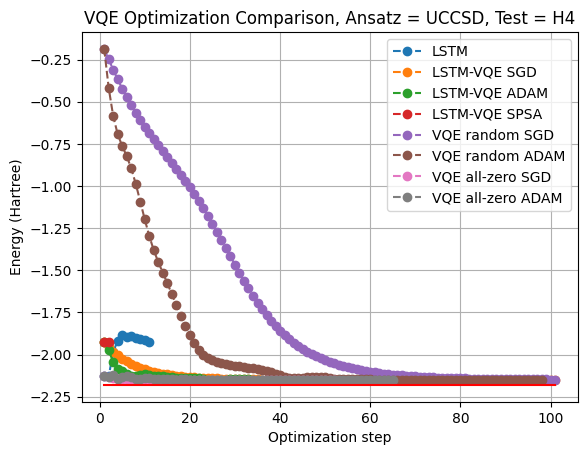

In [ ]:
E_fci = test_set.fci_energy
#plt.figure(figsize = (20,10))
plt.plot(range(1, len(lstm_losses_u) + 1), lstm_losses_u, marker='o', label='LSTM', ls="dashed")
plt.plot(range(1, len(lstm_energy_history_u_sgd) + 1), lstm_energy_history_u_sgd, marker='o', label='LSTM-VQE SGD', ls="dashed")
plt.plot(range(1, len(lstm_energy_history_u_adam) + 1), lstm_energy_history_u_adam, marker='o', label='LSTM-VQE ADAM', ls="dashed")
plt.plot(range(1, len(lstm_energy_history_u_spsa) + 1), lstm_energy_history_u_spsa, marker='o', label='LSTM-VQE SPSA', ls="dashed")
#plt.plot(range(1, len(lstm_energy_history_dynamical) + 1), lstm_energy_history_dynamical, marker='o', label='LSTM-VQE LR dynamical', ls="dashed")
plt.plot(range(1, len(vqe_energy_history_random_sgd) + 1), vqe_energy_history_random_sgd, marker='o', label='VQE random SGD', ls="dashed")
plt.plot(range(1, len(vqe_energy_history_random_adam) + 1), vqe_energy_history_random_adam, marker='o', label='VQE random ADAM', ls="dashed")
plt.plot(range(1, len(vqe_energy_history_0_sgd) + 1), vqe_energy_history_0_sgd, marker='o', label='VQE all-zero SGD', ls="dashed")
plt.plot(range(1, len(vqe_energy_history_0_adam) + 1), vqe_energy_history_0_adam, marker='o', label='VQE all-zero ADAM', ls="dashed")
plt.plot(range(1, len(lstm_energy_history_u_sgd) + 1), np.full(len(lstm_energy_history_u_sgd) , E_fci), color="red")
plt.xlabel("Optimization step")
plt.ylabel("Energy (Hartree)")
plt.title("VQE Optimization Comparison, Ansatz = UCCSD, Test = H4")
plt.legend()
plt.grid(True)
plt.show()